<a href="https://colab.research.google.com/github/sirawan1003/22-23camp/blob/main/Assignment_Pupil_Regression_from_Eye_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Center of Black Eye Regression**
Ack: Chitchanok Sangiamwong,Chayanid Chanakarn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **ดึง Dataset มาจาก Google Drive แล้วแตกไฟล์ไปเก็บในโฟลเดอร์ที่สอดคล้องกับชนิดของไฟล์**


In [ ]:
data_images = '/content/Images'
data_annotations = '/content/Annotations'

In [ ]:
!mkdir Images
!mkdir Annotations

In [ ]:
image_file = 'ImagesRight.zip'
annotation_file = 'AnnotationsRight.zip'

###############################
###############################
# อย่าลืม! เปลี่ยนชื่อโฟลเดอร์ให้ตรงกับที่ลง Dataset ไว้จริง
###############################
###############################
!cp -r "/content/drive/MyDrive/Strabismus Prescreening/"$image_file /content/Images
!cp -r "/content/drive/MyDrive/Strabismus Prescreening/"$annotation_file /content/Annotations
%cd Images
!unzip $image_file
!rm $image_file
%cd ..
%cd Annotations
!unzip $annotation_file
!rm $annotation_file
%cd ..

Streaming output truncated to the last 5000 lines.
 extracting: 0007_2m_30P_0V_5H.txt   
 extracting: 0007_2m_30P_10V_-10H.txt  
 extracting: 0007_2m_30P_10V_-15H.txt  
 extracting: 0007_2m_30P_10V_-5H.txt  
 extracting: 0007_2m_30P_10V_0H.txt  
 extracting: 0007_2m_30P_10V_10H.txt  
 extracting: 0007_2m_30P_10V_15H.txt  
 extracting: 0007_2m_30P_10V_5H.txt  
 extracting: 0008_2m_-15P_-10V_-10H.txt  
 extracting: 0008_2m_-15P_-10V_-15H.txt  
 extracting: 0008_2m_-15P_-10V_-5H.txt  
 extracting: 0008_2m_-15P_-10V_0H.txt  
 extracting: 0008_2m_-15P_-10V_10H.txt  
 extracting: 0008_2m_-15P_-10V_15H.txt  
 extracting: 0008_2m_-15P_-10V_5H.txt  
 extracting: 0008_2m_-15P_0V_-10H.txt  
 extracting: 0008_2m_-15P_0V_-15H.txt  
 extracting: 0008_2m_-15P_0V_-5H.txt  
 extracting: 0008_2m_-15P_0V_0H.txt  
 extracting: 0008_2m_-15P_0V_10H.txt  
 extracting: 0008_2m_-15P_0V_15H.txt  
 extracting: 0008_2m_-15P_0V_5H.txt  
 extracting: 0008_2m_-15P_10V_-10H.txt  
 extracting: 0008_2m_-15P_10V_-15H.tx

## **เปิดใช้แพคเกจที่จำเป็นกับงานนี้**

In [ ]:
from collections import namedtuple
import csv
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
# import the necessary packages
from collections import namedtuple
import numpy as np
import cv2
# define the `Detection` object for IOU(
Detection = namedtuple("Detection", ["image_path", "gt", "pred"])
from PIL import Image, ImageOps
# importing XML parsing library for parsing the data
import xml.etree.ElementTree as ET

## **สร้างลิสต์ของ Dataset ในรูปแบบ [image, center of eye]**

In [ ]:
# เชคจำนวนไฟล์ใน Dataset
import glob

image_files = glob.glob(data_images + '/' + '*.jpg')
print(len(image_files))

5726


In [ ]:
import glob
from os.path import exists
from matplotlib import pyplot as patches
TARGET_SIZE = (224, 224)

# The following function will read the text annotation file and return the values for pupil x and y coordinate
def retrieve_annotation(path_to_annotation):
  # Recently added code
  path_to_annotation = data_annotations + '/' + path_to_annotation
  file_exists = exists(path_to_annotation)
  if file_exists:
    annotation_file = open(path_to_annotation, 'r')
    pupil_location = annotation_file.readline().split()
    if (pupil_location != []):
      return([float(pupil_location[0]), float(pupil_location[1])])
    else:
      return([])
  else:
    return([])


data_pros = []
image_files = glob.glob(data_images + '/' + '*.jpg')
image_files_total = len(image_files)
for image_files_count in range(image_files_total):
  image_file = image_files[image_files_count]
  image_filename = image_file.split('/')
  image_filename_only = image_filename[len(image_filename) - 1].split('.jpg')
  sample_name = image_filename_only[0]

  image = Image.open(image_file)
  image_data = np.array(image.getdata()).reshape(image.size[1], image.size[0], 3)

  #--------------------------------------------------------------------------
  # Convert eye to be of TARGET_SIZE size and put it in the
  # TARGET_SIZE image to be used to cross-eye and direct eye
  # regressor
  # NB: Shape: [Width, Height]
  # Calculate scale in horizontal and vertical axis

  pupil_location = retrieve_annotation(sample_name + '.txt')
  if (pupil_location != []):
    # Keep only right eye image and left pupil location
    data_tuple = (image_data, pupil_location)
    data_pros.append(data_tuple)

print(f'Processed {len(data_pros)} samples')
#data_pros = np.array(data_pros)

Processed 5726 samples


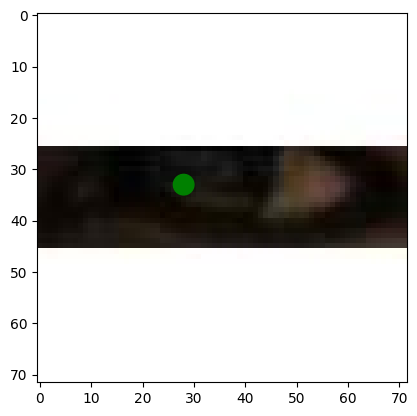

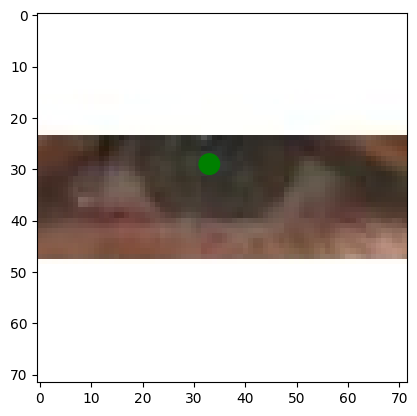

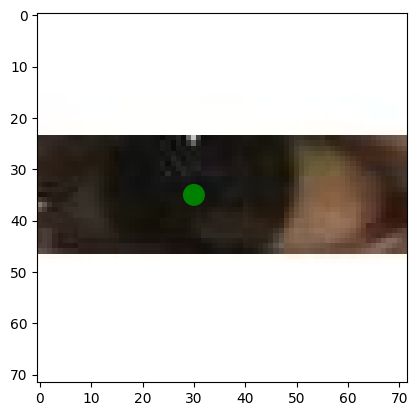

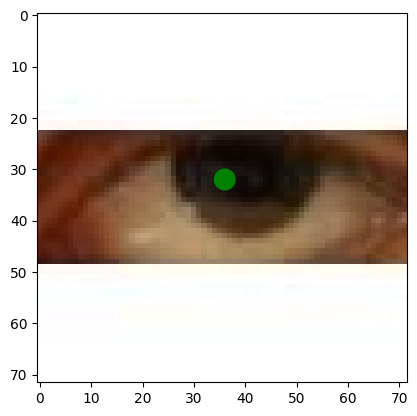

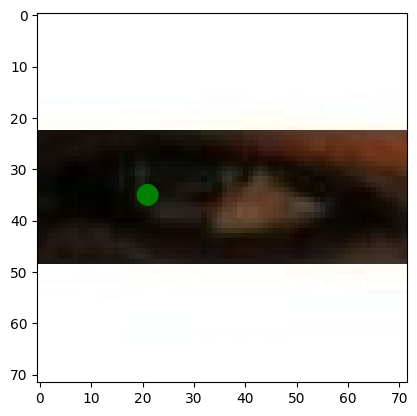

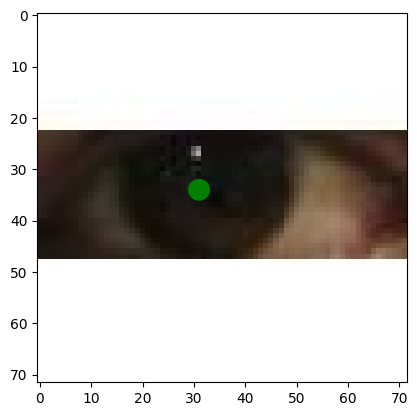

In [ ]:
# ลองดู Dataset ว่าถูกต้องมั๊ย?
# ที่ถูกต้องต้องมีจุดเขียวอยู่ประมาณกลางตาดำ
from matplotlib import pyplot as patches

# For checking lets print 6 eye images along with their pupil locations
for _ in range(6):
  i = np.random.randint(len(data_pros))
  eye_image, eye_annotation = data_pros[i]
  fig, ax = plt.subplots(1)

  pupil_location = patches.Circle((eye_annotation[0],eye_annotation[1]), radius=2, color='green')
  ax.add_patch(pupil_location)
  ax.imshow(eye_image)

## **แยก Dataset ออกเป็น 2 กลุ่ม: Train กับ Validation**

In [ ]:
from PIL import Image
from torchvision.transforms import ToTensor

x_train = []
y_class_train = []
y_box_train = []
x_validation = []
y_class_validation = []
y_box_validation = []
validation_split = 0.2
for image, center in data_pros:
  if np.random.random() > validation_split:
    image = np.array(image)
    x_train.append(preprocess_input(image))
    y_class_train.append(0)
    y_box_train.append(center)
  else:
    image = np.array(image)
    x_validation.append(preprocess_input(image))
    y_class_validation.append(0)
    y_box_validation.append(center)

x_train = np.array(x_train)
y_class_train = np.array(y_class_train)
y_box_train = np.array(y_box_train)
x_validation = np.array(x_validation)
y_class_validation = np.array(y_class_validation)
y_box_validation = np.array(y_box_validation)

# **สร้างโมเดลและสอนโมเดล (ปรับเปลี่ยน Hyperparameter)**

In [ ]:
import pandas as pd
import shutil
import os

TARGET_SIZE = (72, 72)
ep = 200
str_models_w_vars = [
  ['Xception', 'adamax', 'huber'],
  ['Xception', 'nadam', 'huber'],
  ['Xception', 'adam', 'huber'],
]

for str_model_v in str_models_w_vars:
  str_model = str_model_v[0]
  op = str_model_v[1]
  loss_function = str_model_v[2]

  ###############################
  ###############################
  # เปลี่ยนตำแหน่งที่เก็บโมเดลเอง!
  ###############################
  ###############################
  str_save_folder = "/content/drive/MyDrive/Colab Notebooks/Strabismus/Models/Batch_Student_Assignment/" + str(ep) + 'Epochs/' + str_model + "_" + op + "_" + loss_function
  str_save_folder += "_noCrop_suffix_centered - PupilFromEye - 72/"

  print('########', str_model, ep, op, loss_function, TARGET_SIZE)
  print('######## Save to: ' + str_save_folder)

  # Load base Xception model
  base_model = Xception(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

  # Modify the model by chopping at the desired layer
  chopped_model = Model(inputs=base_model.input, outputs=base_model.layers[90].output)

  # Regression output (for localization or other regression tasks)
  localization_output = Flatten()(chopped_model.output)
  localization_output = Dense(units=2, activation='linear')(localization_output)  # Using 'linear' for regression

  # Create the final model
  model_final = Model(inputs=chopped_model.input, outputs=localization_output)

  # Compile the model
  model_final.compile(optimizer=op, loss=loss_function)  # Single loss for regression tasks

  # Summarize the model architecture
  model_final.summary()

  # Train the model
  history = model_final.fit(x_train, y_box_train,  # Only pass the regression target
                            validation_data=(x_validation, y_box_validation),
                            epochs=ep, verbose=True)

######## Xception 200 adamax huber (72, 72)
######## Save to: /content/drive/MyDrive/Colab Notebooks/Strabismus/Models/Batch_Student_Assignment/200Epochs/Xception_adamax_huber_noCrop_suffix_centered - PupilFromEye - 72


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 72, 72, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 35, 35, 32)     │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 35, 35, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 35, 35, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 33, 33, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 33, 33, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 33, 33, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 33, 33, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 33, 33, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 33, 33, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 33, 33, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 33, 33, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 17, 17, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 17, 17, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 10,317,730 (39.36 MB)

 Trainable params: 10,287,570 (39.24 MB)

 Non-trainable params: 30,160 (117.81 KB)

Epoch 1/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 47s 139ms/step - loss: 5.5200 - val_loss: 4.3956
Epoch 2/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 1.8076 - val_loss: 1.7524
Epoch 3/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 1.4553 - val_loss: 1.6644
Epoch 4/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 1.1482 - val_loss: 1.6320
Epoch 5/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 1.0163 - val_loss: 2.2553
Epoch 6/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 1.1162 - val_loss: 1.6964
Epoch 7/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.8490 - val_loss: 1.3522
Epoch 8/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.8552 - val_loss: 1.6652
Epoch 9/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.7375 - val_loss: 1.4837
Epoch 10/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.7156 - val_loss: 1.4866
Epoch 11/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.6593 - val_loss: 1.7003
Epoch 12/200
143/143 ━

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/drive/MyDrive/Colab Notebooks/Strabismus/Models/Batch_Student_Assignment/200Epochs/Xception_adamax_huber_noCrop_suffix_centered - PupilFromEye - 72.